## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

Подключим библиотеки

In [1]:
#Работа с DataFrame
import pandas as pd

#Декомпозиция на сезонность
from statsmodels.tsa.seasonal import seasonal_decompose

#Графики
import matplotlib.pyplot as plt
import seaborn as sns

#Модели
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


#Метрики
from sklearn.metrics import mean_squared_error

#XGBoost
!pip install xgboost 
import xgboost as xgb
from xgboost import XGBRegressor 


Defaulting to user installation because normal site-packages is not writeable


Откроем данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
print(data.info())
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим на данные

<Figure size 720x1440 with 0 Axes>

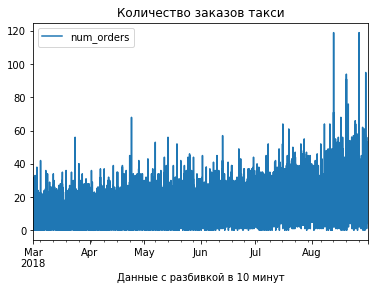

In [3]:
plt.figure(figsize=(10, 20))
data.plot()
plt.xlabel('Данные с разбивкой в 10 минут')
plt.title('Количество заказов такси')
plt.legend()
plt.show()


Cгруппируем данные по 1 часу, так как треуется предсказать на 1 час вперед

<Figure size 720x1440 with 0 Axes>

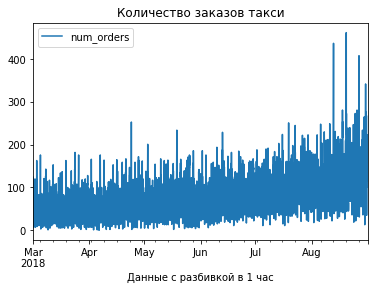

In [4]:
#data = data.resample('1H').mean()
data = data.resample('1H').sum()
plt.figure(figsize=(10, 20))
data.plot()
plt.xlabel('Данные с разбивкой в 1 час')
plt.title('Количество заказов такси')
plt.legend()
plt.show()

* В данных нет пропусков
* Данные с февраля 2018 года до конца августа 2018 года.
* Столбец год не нужен, так как данные за 1 год
* Столбец месяц не нужен, так как данные за феварль - август, не увидим сезонность
* Столбец день не лишний, но не дает много иноформации. Информативнее будет оставить день недели и добавить разграничение на выходные или будни. Гипотеза в том, что паттерн заказов такси сильно отличаются в будни и выходные. В будни больше заказываю на работу/с работы, в выходные наоборот утром заказов меньше
* Также оставляем часы, так как нас интересует прогноз на следующий час

In [5]:
def make_datetime(data):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['is_weekend'] = ((pd.DatetimeIndex(data.index).dayofweek) // 5 == 1).astype(int)

In [6]:
make_datetime(data)
display(data.head(5))

,num_orders,day_of_week,hour,is_weekend
datetime,,,,
2018-03-01 00:00:00,124,3,0,0
2018-03-01 01:00:00,85,3,1,0
2018-03-01 02:00:00,71,3,2,0
2018-03-01 03:00:00,66,3,3,0
2018-03-01 04:00:00,43,3,4,0


Добавим недельное скользящее среднее

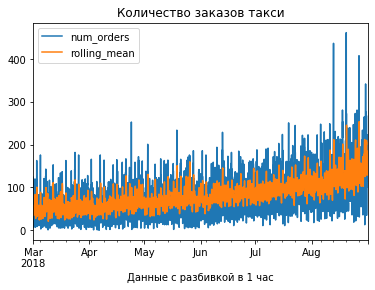

In [25]:
data['rolling_mean'] = data['num_orders'].shift(1).rolling(7).mean()
data['num_orders'].plot()
data['rolling_mean'].plot()
plt.xlabel('Данные с разбивкой в 1 час')
plt.title('Количество заказов такси')
plt.legend()

Недельное скользящее среднее хорошо сглаживает выбросы

Посмотрим на сезонность, тренд и остатки

In [8]:
#Уберем скользящее среднее из данных для сезонности и трендов, так как содержит пропуски
data_trend = data.drop(columns = 'rolling_mean')
decomposed = seasonal_decompose(data_trend['num_orders'])

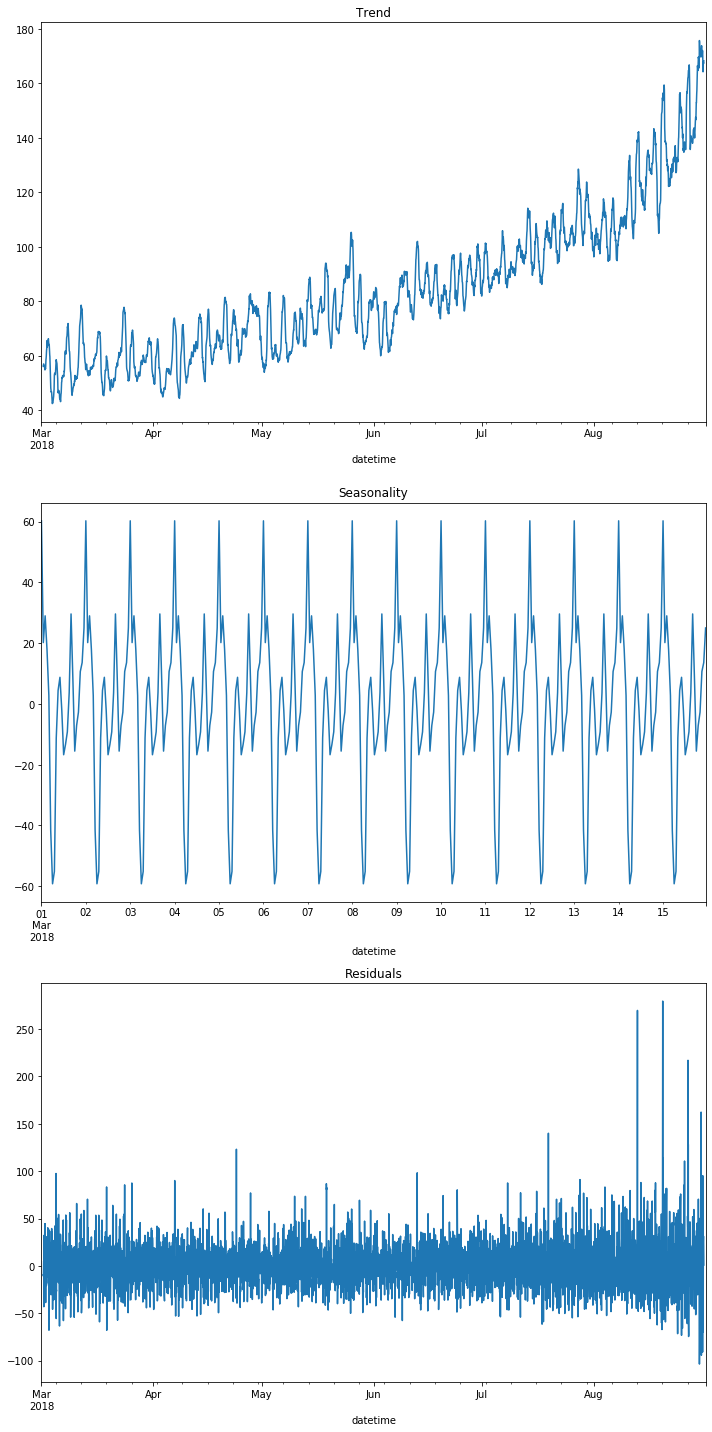

In [9]:
plt.figure(figsize=(10, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

* Видно, что тренд положительный: количество поездок растет с наступлением лета. 
* Из графика сезонности на 2 недели видно, что количество поездок не зависит от дня. Посмотрим за другой месяц, например, июнь

Text(0.5, 1.0, 'Seasonality')

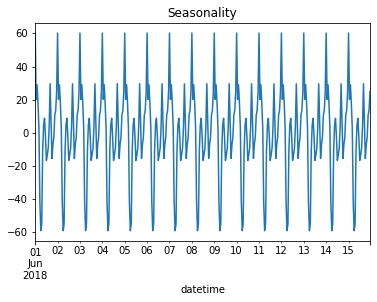

In [10]:
decomposed.seasonal['2018-06-01':'2018-06-15'].plot(ax=plt.gca())
plt.title('Seasonality')

Для июля распредление количества поездок в течении дня не поменялась

Для обучения моделе также добавим лаги. Добавим 3 дневных лага, так как это уже половина недели

In [11]:
def make_lags(data, max_lag):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [12]:
make_lags(data, 3)
data.head(5)

,num_orders,day_of_week,hour,is_weekend,rolling_mean,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,0,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,0,NaN,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,0,NaN,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,0,NaN,71.0,85.0,124.0
2018-03-01 04:00:00,43,3,4,0,NaN,66.0,71.0,85.0


# 2. Обучение и Тестирование

За контрольную модель возьмем линейную ререссию

In [13]:
#Удалим скользящее среднее и первые 3 строки с пропускми из-за лагов
data_train = data.drop(columns = 'rolling_mean')[3:]
display(data_train.head(5))
#Разделим данные
features = data_train.drop('num_orders',axis = 1)
target = data_train['num_orders']
train_features,test_features,train_target,test_target = train_test_split(features,target, shuffle=False, test_size=0.1)
model = LinearRegression()
model = model.fit(train_features,train_target)
train_pred = model.predict(train_features)
test_pred = model.predict(test_features)
print("RMSE обучающей выборки:", round(mean_squared_error(train_target,train_pred)**0.5,2))
print("RMSE тестовой выборки: ", round(mean_squared_error(test_target, test_pred)**0.5,2))

,num_orders,day_of_week,hour,is_weekend,lag_1,lag_2,lag_3
datetime,,,,,,,
2018-03-01 03:00:00,66,3,3,0,71.0,85.0,124.0
2018-03-01 04:00:00,43,3,4,0,66.0,71.0,85.0
2018-03-01 05:00:00,6,3,5,0,43.0,66.0,71.0
2018-03-01 06:00:00,12,3,6,0,6.0,43.0,66.0
2018-03-01 07:00:00,15,3,7,0,12.0,6.0,43.0


RMSE обучающей выборки: 31.66
RMSE тестовой выборки:  56.51


RMSE на тестовой выборке равен 57, что не удовлетворяет условиям задачи (меньше 48). Попробуем сделать RMSE еще меньше с помощью XGBoost

In [14]:
xgb_reg = XGBRegressor()
xgb_reg.fit(train_features, train_target)
train_pred = xgb_reg.predict(train_features)
test_pred = xgb_reg.predict(test_features)
print("RMSE обучающей выборки:", round(mean_squared_error(train_target,train_pred)**0.5,2))
print("RMSE тестовой выборки: ", round(mean_squared_error(test_target, test_pred)**0.5,2))

[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE обучающей выборки: 22.72
RMSE тестовой выборки:  51.54


Получили еще меньший RMSE, причем не потеряли в скорости. Но так и не преодолели планку в 48. Подберем параметры для XGBoost для снижения RMSE

In [15]:
#Обозначим данные для XGBoost

x_learn,x_test, y_learn,y_test = train_test_split(features,target, test_size=0.1,random_state=100500)
x_train,x_valid,y_train,y_valid = train_test_split( x_learn, y_learn, test_size=0.25,random_state=100500)

dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
dtest = xgb.DMatrix(x_test, label=y_test)



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Обозначим сетку параметров с рандомными значениями, которые будем подбирать. Код по подбору параметра из статьи: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

<div style="background: White ; padding: 5px; border: 1px solid purple; border-radius: 5px;">
    <font color='purple'> <b><u>Комментарий студента</u></b>

<br />

In [16]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear',
    }

num_boost_round = 30

Подберем параметры max_depth и min_child_weight

In [17]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    mean_mae = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\RMSE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_mae))
    

CV with max_depth=9, min_child_weight=5
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


\RMSE 26.797441400000004 for 15 rounds
CV with max_depth=9, min_child_weight=6
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
\RMSE 26.648390600000006 for 18 rounds
CV with max_depth=9, min_child_weight=7
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear i

Наилучшие параметры max_depth и min_child_weight

In [18]:
params['max_depth'] = 9
params['min_child_weight'] = 7

Подберем параметры subsample и colsample

In [19]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]
min_mae = float("Inf")
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    mean_mae = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_mae))



CV with subsample=1.0, colsample=1.0
[19:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	RMSE 26.7133802 for 16 rounds
CV with subsample=1.0, colsample=0.9
[19:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	RMSE 26.8943062 for 15 rounds
CV with subsample=1.0, colsample=0.8
[19:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fa

Наилучшие параметры subsample и colsample

In [20]:
params['subsample'] = 1
params['colsample'] = 0.8

Подберем параметр eta

In [21]:
%time
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    params['eta'] = eta
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['rmse'],early_stopping_rounds=10)
    mean_mae = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_mae))

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 9.54 µs
CV with eta=0.3
[19:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 593 ms, sys: 10.5 ms, total: 604 ms
Wall time: 624 ms
	RMSE 26.3010272 for 13 rounds

CV with eta=0.2
[19:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:27] WARNING: /workspace/src/objec

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  if __name__ == '__main__':


CPU times: user 749 ms, sys: 16 ms, total: 765 ms
Wall time: 770 ms
	RMSE 26.0976898 for 26 rounds

CV with eta=0.1
[19:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 784 ms, sys: 7.89 ms, total: 792 ms
Wall time: 794 ms
	RMSE 26.566240599999997 for 29 rounds

CV with eta=0.05
[19:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squareder

Наилучший параметр eta

In [22]:
params['eta'] = .2

In [23]:
#Обучим модель XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dvalid, "Train")],
    early_stopping_rounds=10
)
print('RMSE XGBoost = ',round((mean_squared_error(model.predict(dtest), y_test))**0.5,0))

[19:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Train-rmse:82.0134
Will train until Train-rmse hasn't improved in 10 rounds.
[1]	Train-rmse:68.7521
[2]	Train-rmse:58.8116
[3]	Train-rmse:50.93
[4]	Train-rmse:45.0409
[5]	Train-rmse:40.7165
[6]	Train-rmse:37.2471
[7]	Train-rmse:35.3015
[8]	Train-rmse:33.6531
[9]	Train-rmse:32.24
[10]	Train-rmse:31.125
[11]	Train-rmse:30.3402
[12]	Train-rmse:29.7832
[13]	Train-rmse:29.3699
[14]	Train-rmse:29.1299
[15]	Train-rmse:28.8889
[16]	Train-rmse:28.7097
[17]	Train-rmse:28.5686
[18]	Train-rmse:28.4749
[19]	Train-rmse:28.4756
[20]	Train-rmse:28.4531
[21]	Train-rmse:28.3579
[22]	Train-rmse:28.3338
[23]	Train-rmse:28.2948
[24]	Train-rmse:28.1926
[25]	Train-rmse:28.1528
[26]	Train-rmse:28.1933
[27]	Train-rmse:28.2197
[28]	Train-rmse:28.1986
[29]	Train-rmse:28.1274
RMSE XGBoost =  28.0


### Вывод
* Существует тренд на увеличения количества поездок с наступлением лета
* Не видим различие в количетсве поездок по дням
* Наилучшая прогнозная модель - XGBoost с подбором параметров. Результат по метрике RMSE снизился с 52 до 27 в сравнении с контрольной моделью линейной регрессии. Все-таки стоит подбирать параметры :) 
